# Dataset
https://huggingface.co/datasets/medalpaca/medical_meadow_cord19

# Install Required Libraries

In [ ]:
!pip install "transformers[sentencepiece]" datasets sacrebleu rouge_score py7zr -q
!pip install evaluate
!pip install bert_score
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 12.0 MB/s eta 0:00:00
   ━━━━

# Import Libraries

In [ ]:
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Check GPU availability

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Pre-trained PEGASUS Model and Tokenizer

In [ ]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

# Load and Prepare the Dataset

In [ ]:
dataset_name = "medalpaca/medical_meadow_cord19"
data = load_dataset(dataset_name, split='train')
num_samples = 500
dataset_samsum = data.select(range(num_samples)).train_test_split(test_size=0.2)

print(f"Features: {dataset_samsum['train'].column_names}")

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

medical_meadow_cord19.json:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/821007 [00:00<?, ? examples/s]

Features: ['output', 'input', 'instruction']


# Define Helper Functions for Data Processing and Evaluation

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """Split dataset into smaller batches for simultaneous processing."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i:i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="input",
                               column_summary="output"):
    """Calculate ROUGE score on the test dataset."""
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                             for s in summaries]

        decoded_summaries = [d.replace("<n>", "\n") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

# Evaluate the Pre-trained Model on the Test Set

In [ ]:
rouge_metric = evaluate.load('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, batch_size=8)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = {rn: score[rn] for rn in rouge_names}

rouge_df = pd.DataFrame(rouge_dict, index=["pegasus"])
print(rouge_df)

100%|██████████| 13/13 [02:09<00:00,  9.94s/it]


           rouge1    rouge2    rougeL  rougeLsum
pegasus  0.244406  0.100007  0.180423   0.201486


# Inspect a Sample Input from the Test Set

In [ ]:
dataset_samsum['test'][1]['input']

'Introduction Healthcare workers’ work performance and mental health are associated with positive mental health outcomes and directly related to increased productivity and decreased disability costs. Methods We conducted a systematic review to identify factors associated with work performance of healthcare workers during a pandemic and conducted a meta-analysis of the prevalence of mental health outcomes in this context. Primary papers were collected and analysed using the Population/Intervention/Comparison/Outcome framework and using the Preferred Reporting Items for Systematic Reviews and Meta-Analyses guidelines. To critically appraise the studies included in the review, we used the AXIS appraisal tool to assess each cross-sectional study’s quality. Results The study identified nine factors associated with the work performance and mental health of healthcare workers, including experiencing feelings of depression, anxiety, having inadequate support, experiencing occupational stress, 

# Generate and Print a Summary Using the Pipeline

In [ ]:
from transformers import pipeline

# Use GPU if available
pipe = pipeline('summarization', model=model_ckpt, device=0)

# Get the summary from the test dataset
pipe_out = pipe(dataset_samsum['test'][1]['input'])

# Clean the summary output to replace <n> with a newline
summary = pipe_out[0]['summary_text'].replace('<n>', '\n')

print(summary)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The study identified nine factors associated with the work performance and mental health of healthcare workers .
Regular and sustained interventions, including the use of information and communication technologies such as telehealth, are warranted .


# Visualize Token Length Distributions

Token indices sequence length is longer than the specified maximum sequence length for this model (1107 > 1024). Running this sequence through the model will result in indexing errors


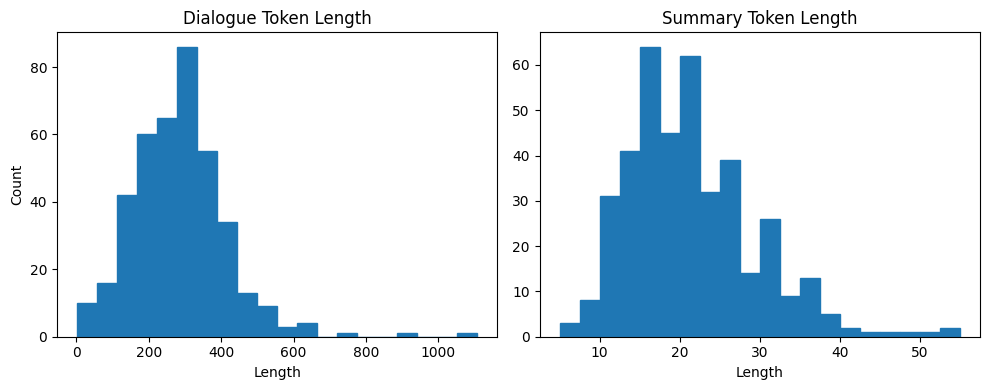

In [ ]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['input']]
summary_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['output']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# Prepare the Dataset for Training


In [ ]:
def convert_examples_to_features(example_batch):
    """Convert input and output examples to token IDs."""
    input_encodings = tokenizer(example_batch['input'], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['output'], max_length=128, truncation=True)

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Set Up Data Collator for Sequence-to-Sequence Tasks

In [ ]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

# Enable Gradient Checkpointing and Adjust Tokenizer

In [ ]:
model_pegasus.gradient_checkpointing_enable()


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)


# Configure and Initialize the Trainer for Model Training

In [ ]:
from transformers import Trainer, TrainingArguments
from accelerate import Accelerator


accelerator = Accelerator()

train_dataset = dataset_samsum_pt['train']
eval_dataset = dataset_samsum_pt['test']

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16,
    report_to='none'
)

trainer = Trainer(
    model=model_pegasus,
    args=trainer_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-068752d204d1>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train the Model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=25, training_loss=4.331600875854492, metrics={'train_runtime': 197.4023, 'train_samples_per_second': 2.026, 'train_steps_per_second': 0.127, 'total_flos': 320414514806784.0, 'train_loss': 4.331600875854492, 'epoch': 1.0})

# Re-evaluate the Fine-tuned Model on the Test Set

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text='input', column_summary='output'
)

rouge_dict = {rn: score[rn] for rn in rouge_names}
rouge_df = pd.DataFrame(rouge_dict, index=["pegasus"])
print(rouge_df)

100%|██████████| 50/50 [35:28<00:00, 42.56s/it]


           rouge1   rouge2    rougeL  rougeLsum
pegasus  0.239664  0.10323  0.181758   0.203918


# Save the Fine-tuned Model and Tokenizer

In [ ]:
model_pegasus.save_pretrained("pegasus-samsum-model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Generate and Compare a Sample Summary

In [ ]:
sample_text = dataset_samsum["test"][0]["input"]
reference = dataset_samsum["test"][0]["output"]

In [ ]:
pipe = pipeline("summarization", model="pegasus-samsum-model", tokenizer=tokenizer, device=0)
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

In [ ]:
print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hybrid models to detect dementia based on Machine Learning can provide accurate diagnoses in individuals with neurological disorders and cognitive complications caused by Human Immunodeficiency Virus (HIV) infection. This study proposes a hybrid approach, using Machine Learning algorithms associated with the multicriteria method of Verbal Decision Analysis (VDA). Dementia, which affects many HIV-infected individuals, refers to neurodevelopmental and mental disorders. Some manuals standardize the information used in the correct detection of neurological disorders with cognitive complications. Among the most common manuals used are the DSM-5 (Diagnostic and Statistical Manual of Mental Disorders, 5th edition) of the American Psychiatric Association and the International Classification of Diseases, 10th edition (ICD-10)—both published by World Health Organization (WHO). The model is designed to explore the predictive of specific data. Furthermore, a well-defined database data se